# Метод Ньютона

## Метод Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданному правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

## Теорема сходимости (Ю. Е. Нестеров Введение в выпуклую оптимизацию, $\S$ 1.2)

**Теорема.** Пусть функция $f(x)$
- дважды дифференцируема и её гессиан удовлетворяет условию Липшица с константой $M$
- существует точка локального минимума с положительно определённым гессианом

$$
f''(x^*) \succeq l\mathbf{I}, \; l > 0
$$

- начальная точка $x_0$ достаточно близка к точке минимума, в частности

$$
\|x_0 - x^*\|_2 \leq \frac{2l}{3M}
$$

Тогда метод Ньютона сходится **квадратично**:

$$
\|x_{k+1} - x^* \|_2 \leq \dfrac{M\|x_k - x^*\|^2_2}{2 (l - M\|x_k - x^*\|_2)}
$$

### Пример

Применим метод Ньютона для поиска корня следующей функции

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

и определим область сходимости.

## Использование метода сопряжённых градиентов в методе Ньютона

- В методе Ньютона надо решать линейную систему $H(x_k) h_k = -f'(x_k)$ для поиска направлению движения
- Если функция сильно выпуклая, то $H(x_k) \in \mathbb{S}^n_{++}$ и для решения системы можно использовать метод сопряжённых градиентов. В этом случае метод называют **неточный метод Ньютона**.
- Что нового это даёт
    - Явно хранить гессиан не нужно, достаточно умножать его на вектор
    - Можно регулировать точность решения системы и не решать её очень точно вдали от решения. **Важно**: неточное решение может не быть направлением убывания! 
    - Сходимость будет только локально сверхлинейной при начале выбора шага с $\alpha_0 = 1$, как и в методе Ньютона

## Вычислительная сложность и эксперименты

Узкие места метода Ньютона:

- формирование и хранение гессиана
- решение систем линейных уравнений

$$
f''(x_k)h = -f'(x_k)
$$

### Сравнение с градиентным спуском
$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

- Вспомните, как вычислять градиент и гессиан от такой функции

In [71]:
import numpy as np

import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import sklearn.datasets as skldata
n = 700
m = 2000


X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3, random_state=42)
C = 1

#### Точное решение с помощью CVXPy

In [72]:
import cvxpy as cvx
x = cvx.Variable(n)

obj = cvx.Minimize(cvx.norm(x, 2)**2 / 2 + C * cvx.sum(cvx.logistic(cvx.multiply(-y, X * x))) / m)
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 712704, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 6702, constraints m = 14704
Cones:	linear vars: 2000
	soc vars: 704, soc blks: 2
	exp vars: 12000, dual exp vars: 0
Setup time: 3.10e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.48e-01 
   100| 3.71e-01  2.84e-03  1.17e-01  8.86e-02  2.44e-01  6.67e-15  3.25e+00 
   200| 1.51e-01  3.06e-03  6.27e-03  3.39e-01  3.50e-01  7.26e-15  7.

#### Вспомогательные функции

In [73]:
@jax.jit
def f(w):
    return jnp.linalg.norm(w)**2 / 2 +  C * jnp.mean(jnp.logaddexp(jnp.zeros(X.shape[0]), -y * (X @ w)))

grad_f = jax.jit(jax.grad(f))
hess_f = jax.jit(jax.hessian(f))
x0 = jnp.ones(n)
%timeit grad_f(x0).block_until_ready()
%timeit hess_f(x0).block_until_ready()

1.46 ms ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
46.4 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Реализация метода Ньютона

In [74]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

### Сравнение с градиентным спуском

In [75]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f,
                                 ss.Backtracking("Armijo", rho=0.4, beta=0.1, init_alpha=1.),
                                linsolver=jnp.linalg.solve)
# newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.ConstantStepSize(5e-1))
x_newton = newton.solve(x0, tol=1e-7, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 12 iterations
Function value = 0.45668477826106013
Norm of gradient = 4.952606460726703e-09


In [76]:
gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.))
# agd = methods.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3))
# gd = methods.fo.GradientDescent(f, grad_f, ss.ConstantStepSize(5e-3))
x_gd = gd.solve(x0, tol=1e-5, max_iter=3000, disp=True)
# x_agd = agd.solve(x0, tol=1e-3, max_iter=3000, disp=True)

Required tolerance achieved!
Convergence in 732 iterations
Function value = 0.4566847783000756
Norm of gradient = 9.930033236084605e-06


In [77]:
import scipy.sparse.linalg as spsplin 
def hess_mat(x):
    H = hess_f(x)
    return spsplin.LinearOperator((n, n), matvec=lambda w: H @ w)

@jax.jit
def hvp(primals, tangents):
    return jax.jvp(grad_f, primals, tangents)[1]

def jax_hess_mat(x):
    return spsplin.LinearOperator((n, n), matvec=lambda w: hvp((x,), (w,)))

inexact_newton = methods.so.InexactNewtonMethod(f, grad_f, jax_hess_mat, 
                                                ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.))
x_inn = inexact_newton.solve(x0, tol=1e-7, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 20 iterations
Function value = 0.4566847782610611
Norm of gradient = 8.274121024757551e-08


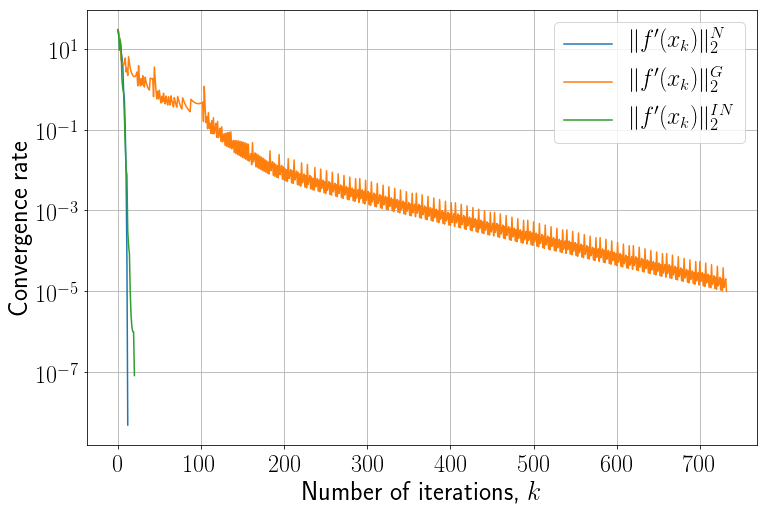

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
    
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
# Inexact Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in inexact_newton.get_convergence()], label="$\| f'(x_k) \|^{IN}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Convergence rate", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.grid(True)
plt.legend(loc="best", fontsize=24)

#### Сравнение времени работы

In [79]:
%timeit newton.solve(x0, tol=1e-3, max_iter=5000).block_until_ready()
%timeit gd.solve(x0, tol=1e-3, max_iter=5000).block_until_ready()
%timeit inexact_newton.solve(x0, tol=1e-3, max_iter=50).block_until_ready()

756 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.3 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
754 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Метод Ньютона даёт очень точное решение за возможно (асимптотически) длительное время
- Градиентный спуска даёт не очень точное решение, но гораздо быстрее
- Часто бывает, что очень точное решение не требуется, поэтому градиентный спуск может быть предпочтительнее

## Pro & Contra

Pro

- квадратичная сходимость вблизи решения
- высокая точность полученного решения
- аффинная инвариантность
- параметры слабо влияют на скорость сходимости

Contra

- необходимо хранить гессиан на каждой итерации: $O(n^2)$ памяти
- необходимо решать линейные системы: $O(n^3)$ операций
- гессиан может оказаться вырожден
- гессиан может не быть положительно определён $\to$ направление $-(f''(x))^{-1}f'(x)$ может не быть направлением убывания

## Сравнение с градиентным методом (Б.Т. Поляк Введение в оптимизацию, гл. 3, $\S$ 1 )

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | :---
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды дифференцируема; гессиан липшицев, положительно определён


## Что дальше?

- **Сложность:** как избавиться от решения систем линейных уравнений и хранения гессиана?
- **Сходимость:** как совместить локально квадратичную и глобально линейную скорости? Желательно получить глобально квадратичную сходимость!
- Требования к $f(x)$ необходимо минимизировать
- Квазиньютоновские методы частично решают эти проблемы

## Как уменьшить сложность хранения и вычисления?

- Сложность вычисления можно уменьшить с помощью
    - Квазиньютоновские методы, они же методы переменной метрики
    - Требуется хранение матрицы $n \times n$
    
- Сложность вычисления и хранения можно уменьшить 
    - квазиньютоновские методы с ограниченной памятью, например [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (Limited Broyden-Fletcher-Goldfarb-Shanno)
    - НЕ требуется хранить матрицу
    - вместо этого хранятся $k \ll n$ векторов из $\mathbb{R}^n$

## Общая схема квазиньютоновских методов

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

## BFGS

\begin{align*}
& \min_H \| H_k - H \| \\
\text{s.t. } & H = H^{\top}\\
& Hy_k = s_k
\end{align*}

Формула пересчёта для метода BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

### Детали реализации

- Не должно быть операций сложностью $O(n^3)$, то есть никаких матричных умножений и решений линейных систем (cf. [реализацию в SciPy v. 0.18.1](https://github.com/scipy/scipy/blob/v0.18.1/scipy/optimize/optimize.py#L874-L976))
- Только правило Вольфа гарантирует соблюдения условия кривизны $y_k^{\top}s_k > 0$
- Параметры в правиле Вольфа обычно следующие
    - $\alpha_0 = 1$ необходим для сверхлинейной скорости
    - $\beta_1 = 10^{-4}$, $\beta_2 = 0.9$
- Способы инициализации $H_0$
    - единичная матрица
    - $H_0 = \frac{y_0^{\top}s_0}{y_0^{\top}y_0}I$ **после** первого шага, но до вычисления $H_1$.При вычислении $x_1$  используется $H_0 = I$
    - $H_0 = \delta \|g_0\|^{-1}_2 I$, параметр $\delta$ необходимо заранее задать


```python
def update_H(x_next, x_current):
    
    current_grad = grad(x_next)
    
    s = x_next - x_current
    
    y = current_grad - grad_mem[-1]
    
    rho = 1. / y.dot(s)
    
    if H is None:
        
        H = np.eye(x_current.shape[0]) / y.dot(y) / rho
        
    Hy = H.dot(y)
    
    Hys = np.outer(Hy, s)
    
    ss = np.outer(s, s)
    
    H = rho * ss + H - rho * Hys - rho * Hys.T + rho**2 * y.dot(Hy) * ss
    
    x_current = x_next
    
    return H
```

### Сходимость

**Теорема**

Пусть $f$ дважды непрерывно дифференцируема и её гессиан липшицев, также пусть последовательность генерируемая методом BFGS сходится к точке $x^*$ так что $\sum_{k=1}^{\infty} \|x_k - x^*\| < \infty$. Тогда $x_k \to x^*$ сверхлинейно.

### Самокоррекция

- Если BFGS на некоторой итерации даёт плохую оценку обратного гессиана, то через несколько итераций это недоразумение будет **автоматически** исправлено, то есть метод сам скорректирует грубую оценку гессиана
- Это свойство появляется только при правильном способе выбора шага, например при использовании правила Вольфа
- Метод DFP существенно хуже корректирует неточные оценки обратного гессиана
- Всё это будет ниже проиллюстрировано на примерах

## BFGS с ограниченной памятью (L-BFGS)

- В методе BFGS нужна не сама матрица $H$, а только функция умножения её на вектор 
- Поскольку требуется локальная оценка гессиана, старые значения векторов $s$ и $y$ могут портить текущую оценку

**Идея**

- Хранить $k \ll n$ последних векторов $s$ и $y$ - снижение требуемой памяти с $n^2$ до $kn$
- Выполнение умножения на вектор рекурсивно, без явного формирования матрицы $H$

```python
def get_lbfgs_direction(x):
    
    if H is None:
        
        current_grad = grad(x)
        
        return -current_grad
    
    else:
        
        q = current_grad
        
        alpha = np.zeros(len(s_hist))
        
        rho = np.zeros(len(s_hist))
        
        for i in range(len(s_hist) - 1, -1, -1):
            
            rho[i] = 1. / s_hist[i].dot(y_hist[i])
            
            alpha[i] = s_hist[i].dot(q) * rho[i]
            
            q = q - alpha[i] * y_hist[i]
            
        r = q * H
        
        for i in range(len(s_hist)):
            
            beta = rho[i] * y_hist[i].dot(r)
            
            r = r + s_hist[i] * (alpha[i] - beta)
            
    return -r

```

## Эксперименты

### Поиск аналитического центра системы неравенств

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [18]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as scopt
plt.rc("text", usetex=True)

In [19]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

In [20]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [21]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [28]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
    "LBFGS": methods.fo.LBFGS(f, grad_f, hist_size=15),
}

In [31]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.6358138388673
Norm of gradient = 5.4764414156933115e-06
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.6358138388574
Norm of gradient = 7.634435132812511e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.6354485454683
Norm of gradient = 0.051000372994997635
	 Method LBFGS
Required tolerance achieved!
Convergence in 18 iterations
Function value = -706.6358138388711
Norm of gradient = 8.305934116759764e-08
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 18 iterations
Function value = -706.635813838869


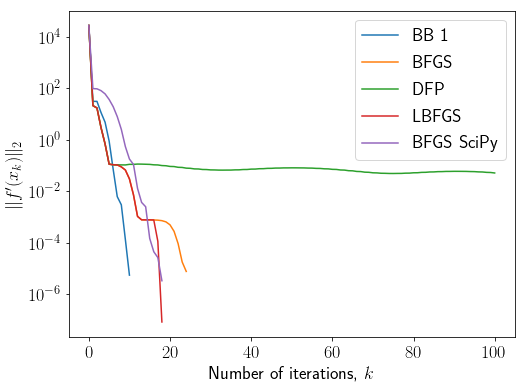

In [32]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [16]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})

	 Method BB 1
6.87 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.12 s ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method DFP


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


9.4 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method LBFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


73.5 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.7 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Плохо обусловленная задача 

In [33]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 50.00000000000009


In [34]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [39]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
    "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "DFP": methods.fo.DFP(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
    "LBFGS": methods.fo.LBFGS(f, gradf, hist_size=5),
#     "Nesterov": methods.fo.AcceleratedGD(f, gradf, ss.ConstantStepSize(1. / n))
}

In [42]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")

scopt_lbfgs_conv = []
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, 
                           options={"maxiter": max_iter, 'maxcor': 5, "ftol": 1e-10, "gtol": 1e-6},
                           callback=lambda x: scopt_lbfgs_conv.append(x),
                           )
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 62 iterations
Function value = -3.3815595574307373
Norm of gradient = 8.79689931952075e-06
	 Method BB 2
Required tolerance achieved!
Convergence in 50 iterations
Function value = -3.3815595574586212
Norm of gradient = 9.815761429486511e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 48 iterations
Function value = -3.381559557463841
Norm of gradient = 8.647232963467307e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -3.3815595574516046
Norm of gradient = 1.3043761756122531e-05
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -3.381190612907183
Norm of gradient = 0.037439767131454436
	 Method LBFGS
Required tolerance achieved!
Convergence in 51 iterations
Function value = -3.3815595574607977
Norm of gradient = 9.050507415074035e-06
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 59 iterations
Function val

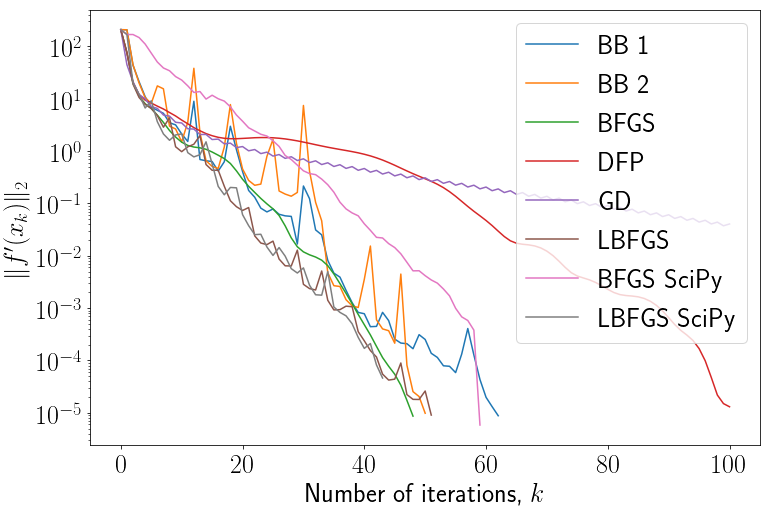

In [43]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:   
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_lbfgs_conv], label='LBFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [45]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=gradf, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-6})

	 Method BB 1
893 µs ± 89.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method BB 2
1.14 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method BFGS
3.72 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method DFP
7.18 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method GD
1.74 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method LBFGS
5.01 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.33 ms ± 785 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
922 µs ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Pro & Contra

Pro:
1. Вместо **точного** вычисления гессиана используется его **оценка**, полученная с помощью градиента и оценки гессиана в предыдущей точке
2. Вместо решения систем линейных уравнений используется текущаю информация о функции и градиенте для аналитического вычисления приближения обращённого гессиана
3. Сложность одной итерации $O(n^2) + ...$ по сравнению с $O(n^3) + ...$ в методе Ньютона
4. Для метода L-BFGS требуется линейное количество памяти по размерности задачи
5. Свойство самокоррекции метода BFGS: если на некоторой итерации обратный гессиан оценен очень грубо, то следующие несколько итераций улучшат оценку
6. Сверхлинейная сходимость к решению задачи минимизации $f$

Contra:
1. Нет универсального рецепта выбора начального приближения $B_0$ или $H_0$
2. Нет разработанной теории сходимости и оптимальности
3. Не любое условие на линейный поиск шага гарантирует выполнения условия кривизны $y^{\top}_ks_k > 0$